In [1]:
# Helpful packages for working with images and factorizations
# using Pkg; Pkg.add("Images")
# using Pkg; Pkg.add("Interact")
# using Pkg; Pkg.add("ImageMagick") # And this allows us to load JPEG-encoded images
using Images, LinearAlgebra, Interact

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/914c23191e59e3852d3d15cfe92655817e94228b-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/914c23191e59e3852d3d15cfe92655817e94228b-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

### Использование SVD для сжатия изображения

В этом упражнении мы будем использовать разложение по сингулярным числам (SVD) для сжатия изображения, чтобы мы могли хранить изображение, не сохраняя «ненужную» информацию. Для начала давайте определим разложение по единственному значению. В SVD мы берем матрицу $A$ и разлагаем ее так, чтобы

$$A = USV^T$$

где матрицы $U$ и $V$ являются унитарными и содержат наши особые векторы. Матрица $S$ диагональна и хранит наши сингулярные значения в порядке убывания сверху/слева, снизу/справа. В Джулии наши изображения хранятся в виде массивов, поэтому мы можем рассматривать их как матрицы

In [1]:
file = download("https://uploads6.wikiart.org/images/salvador-dali/the-persistence-of-memory-1931.jpg!Large.jpg")

"C:\\Users\\D395~1\\AppData\\Local\\Temp\\jl_CD7F.tmp"

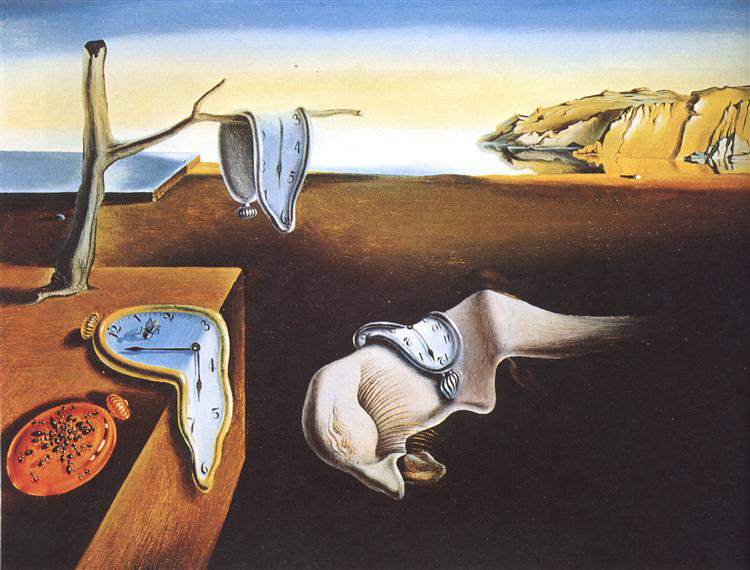

In [4]:
img = load(file)

In [4]:
size(img)

(570, 750)

In [11]:
img[245,280]

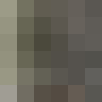

In [12]:
img[140:145,220:225] # Each element in the array is a color

In [13]:
dump(img[24,24])

RGB{Normed{UInt8,8}}
  r: Normed{UInt8,8}
    i: UInt8 0x8b
  g: Normed{UInt8,8}
    i: UInt8 0xa3
  b: Normed{UInt8,8}
    i: UInt8 0xc5


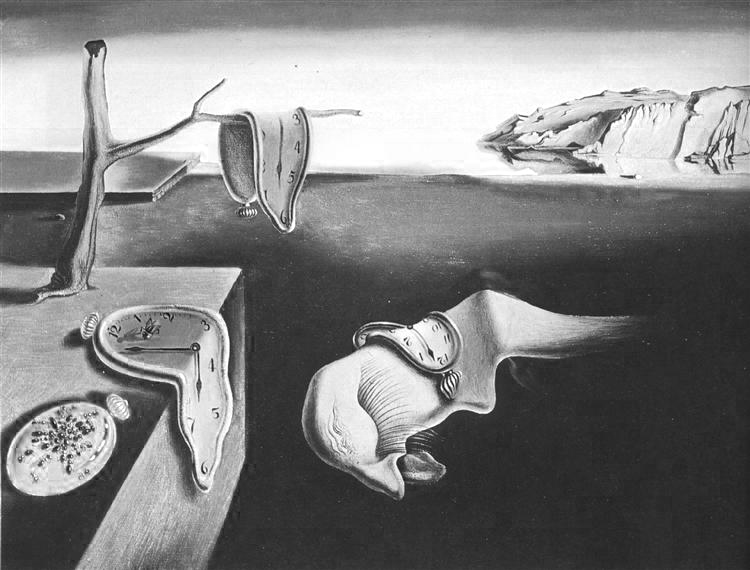

In [5]:
channels = Float64.(channelview(img))
Gray.(channels[1, :, :])

Это означает, что мы можем взять SVD этого изображения. Таким образом, мы можем хранить эту картинку банана как наборы сингулярных векторов и сингулярных значений. 

Это полезно, так как мы обнаружим, что нам не нужно отслеживать все особые векторы и все особые значения для хранения изображения, которое все еще выглядит как банан! Это означает, что мы можем хранить только важную информацию, отбрасывая остальную часть и тем самым «сжимая» изображение. 

Работать с изображениями в оттенках серого немного проще, поэтому давайте поработаем с серой версией этого банана.

Если мы не выбрасываем данные, то возвращаемся к тому, с чего начали:

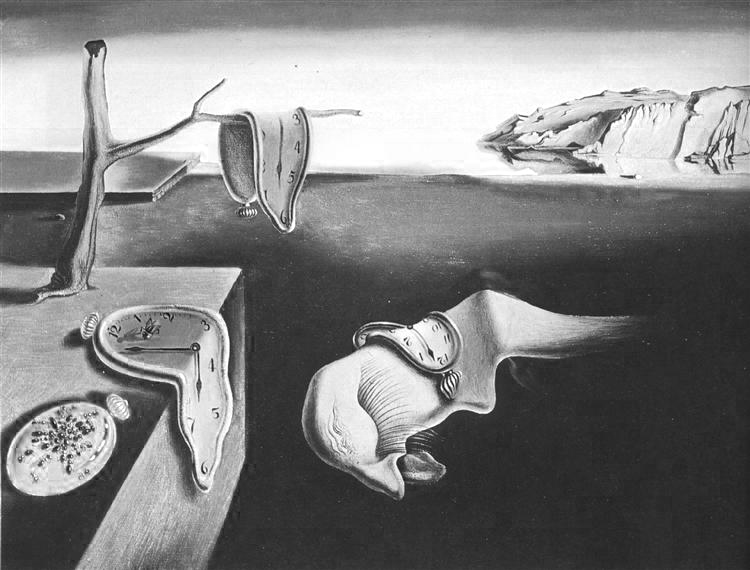

In [6]:
U, S, V = svd(channels[1,:,:])
Gray.(U * Diagonal(S) * V')

Ну, конечно, мы не делаем здесь никакого сжатия - размеры U, S и V больше, чем наша исходная матрица! Это как противоположность сжатия. Ключевым моментом является то, что значения хранятся в порядке убывания, поэтому мы можем начать отбрасывать ненужности.

In [17]:
sum(length.((U, S, V)))

752970

In [18]:
length(img)

427500

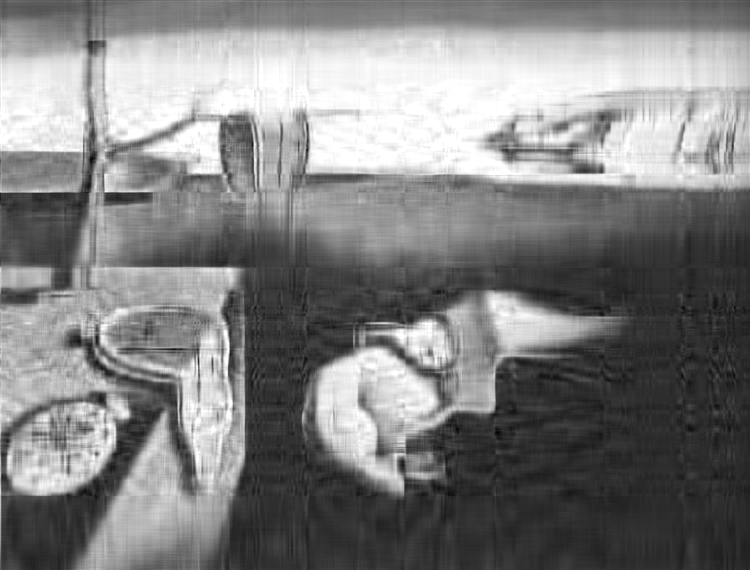

In [7]:
Gray.(U[:, 1:25] * Diagonal(S[1:25]) * V[:, 1:25]')

In [8]:
sum(length.((U[:, 1:25], S[1:25], V[:, 1:25])))/length(img)

0.0772514619883041

Конечно, это всего лишь один канал изображения. Давайте соберем все воедино и посмотрим, как мы можем сжать разные каналы, чтобы найти приемлемый уровень сжатия.

In [14]:
function rank_approx(M, k)
    U, S, V = svd(M)
    
    M = U[:, 1:k] * Diagonal(S[1:k]) * V[:, 1:k]'
    
    M = min.(max.(M, 0.0), 1.)
end

n = 100
@manipulate for k1 in 1:n, k2 in 1:n, k3 in 1:n
    colorview(  RGB, 
                rank_approx(channels[1,:,:], k1),
                rank_approx(channels[2,:,:], k2),
                rank_approx(channels[3,:,:], k3)
    )
    end # ??? interact не отображается

UndefVarError: UndefVarError: channels not defined

**Итак, как мы можем использовать SVD, чтобы определить, какая информация на изображении действительно важна?**

Ответ кроется в сингулярных значениях!

Если у нас есть матрицы $U$, $S$, и $V$ Исходя из нашего изображения, мы можем восстановить это изображение с помощью матричного умножения $USV^T$. 

Взятие этого матричного произведения аналогично суммированию внешних произведений каждой соответствующей пары векторов из $ U $ и $ V $, масштабированных по сингулярному значению ($\sigma$) из $ S $. Другими словами, для (100 x 100) пиксельного изображения

$$A_{image} = USV^T = \sum_{i = 1}^{100} \sigma_i \mathbf{u_i}\mathbf{v_i'} $$

Every outer product $u_i * v_i'$ creates a (100 x 100) matrix. Here we're summing together one hundred (100 x 100) matrices in order to create the original matrix $A_{image}$. The matrices at the beginning of the series -- those that are scaled by **large** singular values -- will be **much** more important in recreating the original matrix $A_{image}$.

This means we can approximate $A_{image}$ as

$$A_{image} \approx \sum_{i = 1}^{n} \sigma_i \mathbf{u_i}\mathbf{v_i'}$$

where $n < 100$.

#### Упражнение

Напишите функцию под названием `compress_image`. Её входные аргументы должны быть изображением и фактором сжатия. Сжатое изображение в градациях серого должно отображаться при вызове `compress_image`.

Например,

```julia
compress_image("images/104_100.jpg", 33)
```

вернет сжатое изображение банана в градациях серого, построенного с использованием 3 особых значений. (Это изображение имеет 100 единичных значений, поэтому используйте `fld (100, 33)`, чтобы определить, сколько особенных значений следует сохранить. `Fld` выполняет `floor division`.)

*Подсказки*: 

* Выполните SVD на «канале» изображения в градациях серого.
* В пустой ячейке выполните `?svd` чтобы найти функцию реализующую SVD.

In [3]:
cd("D:/Science/data") # load не любит кириллицу в пути, 
# а так как мой профиль назван по-русски, то придётся перенести папку и поменять рабочую директорию

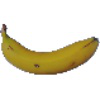

In [5]:
yellowbanana = load("104_100.jpg")

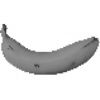

In [6]:
banana = Gray.(yellowbanana)

Note that `banana` is a (100 x 100) matrix that stores a pixel -- information about the color -- at each entry.

In [7]:
size(banana)

(100, 100)

If we take the `channelview` of `banana`, we'll see the numbers that describe the color at each point in the array:

In [8]:
channelview(banana)

100×100 reinterpret(N0f8, ::Array{Gray{N0f8},2}):
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0

Note that you can call `Gray` on the `channelview` of an image to display the image!

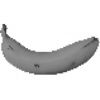

In [9]:
Gray.(channelview(banana))